# Bizbuysell Data Wrangling & Exploration 4

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn 
import nltk
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
sns.set(style="white", font_scale=1.2)
plt.rcParams["figure.figsize"] = [10,8]
pd.set_option.display_max_columns = 0
pd.set_option.display_max_rows = 0

### Load english stopwords

In [4]:
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
stopwords = stopwords.words('english')

### Load dataset

In [5]:
df_in=pd.read_parquet('data/bizbuysell.dataset.3.parquet')

In [6]:
df_in.shape

(27338, 34)

In [7]:
df_in.columns

Index(['id', 'src', 'url', 'title', 'desc', 'local', 'region', 'location',
       'title_loc', 'categories', 'similar', 'details', 'financials', 'price',
       'FEATURE_ID', 'FEATURE_NAME', 'FEATURE_CLASS', 'CENSUS_CODE',
       'CENSUS_CLASS_CODE', 'GSA_CODE', 'OPM_CODE', 'STATE_NUMERIC',
       'STATE_ALPHA', 'COUNTY_SEQUENCE', 'COUNTY_NUMERIC', 'COUNTY_NAME',
       'PRIMARY_LATITUDE', 'PRIMARY_LONGITUDE', 'DATE_CREATED', 'DATE_EDITED',
       'STATE_NAME', 'POVERTY_PERCENT', 'MEDIAN_HOUSEHOLD_INCOME', 'H3_15'],
      dtype='object')

### Price stats

In [8]:
df_in.iloc[0].price

225000.0

In [9]:
df_in[['price']].describe().apply(lambda s: s.apply('{0:.2f}'.format))

,price
count,27338.00
mean,421899.06
std,388090.53
min,1.00
25%,142125.00
50%,285000.00
75%,580000.00
max,1769000.00


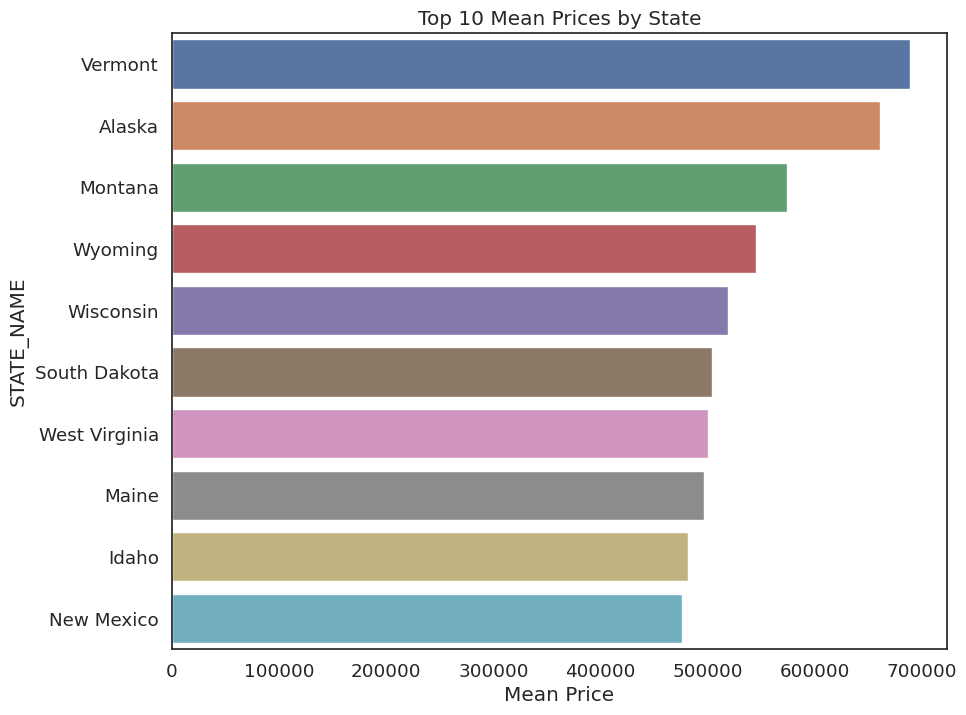

In [10]:
states_price=pd.DataFrame({'Mean Price': df_in.groupby('STATE_NAME')['price'].mean()})
states_price.sort_values('Mean Price',ascending=False,inplace=True)
sns.barplot(y=states_price[0:10].index, x=states_price[0:10]['Mean Price'], orient='h')
plt.title("Top 10 Mean Prices by State")
plt.show()

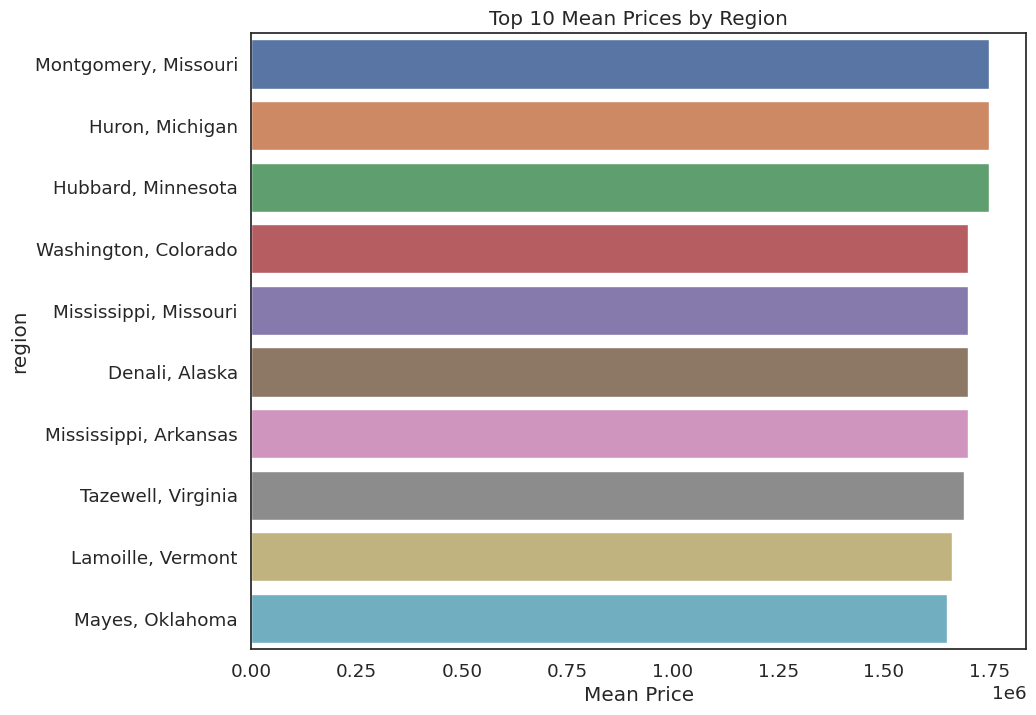

In [11]:
df=df_in
df['region']=df['COUNTY_NAME'] + ', ' + df['STATE_NAME']
region_price=pd.DataFrame({'Mean Price': df.groupby('region')['price'].mean()})
region_price.sort_values('Mean Price',ascending=False,inplace=True)
sns.barplot(y=region_price[0:10].index, x=region_price[0:10]['Mean Price'], orient='h')
plt.title("Top 10 Mean Prices by Region")
plt.show()

<AxesSubplot:xlabel='POVERTY_PERCENT', ylabel='price'>

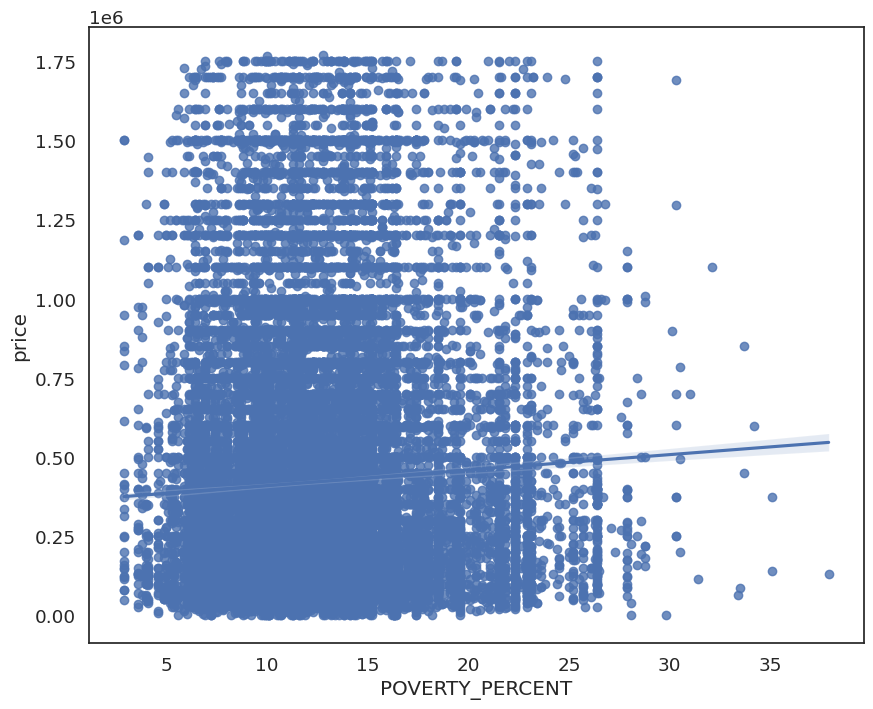

In [46]:
sns.regplot(data=df_in, y="price", x="POVERTY_PERCENT")

<AxesSubplot:xlabel='MEDIAN_HOUSEHOLD_INCOME', ylabel='price'>

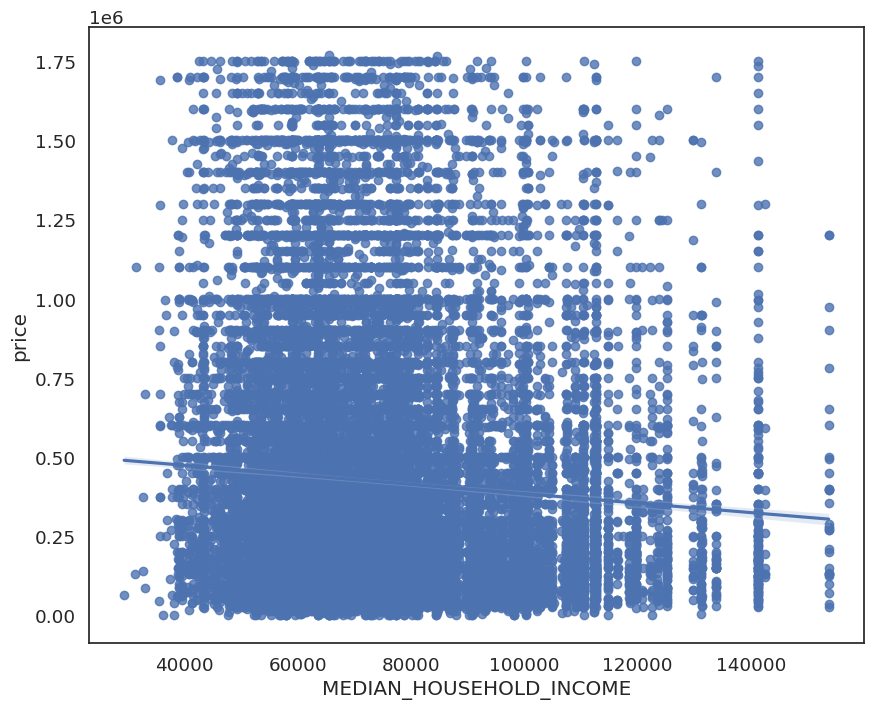

In [47]:
sns.regplot(data=df_in, y="price", x="MEDIAN_HOUSEHOLD_INCOME")

### Location stats

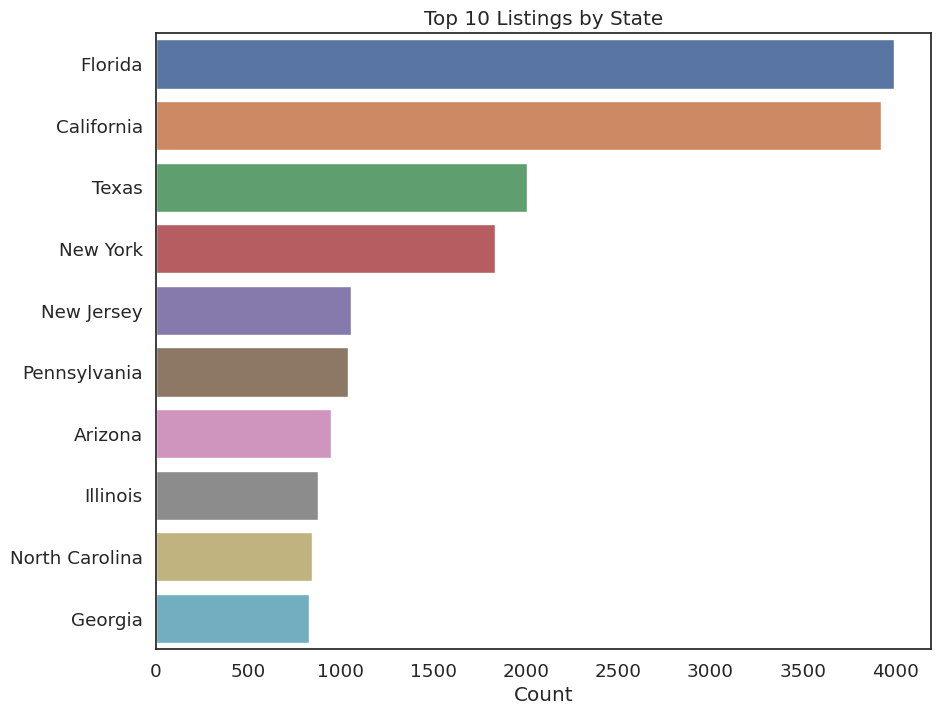

In [14]:
states_vc=pd.DataFrame({'Count': df_in['STATE_NAME'].value_counts()})
sns.barplot(y=states_vc[0:10].index, x=states_vc[0:10]["Count"], orient='h')
#sns.barplot(y=states_vc.index, x=states_vc["Count"], orient='h')
plt.title("Top 10 Listings by State")
plt.show()

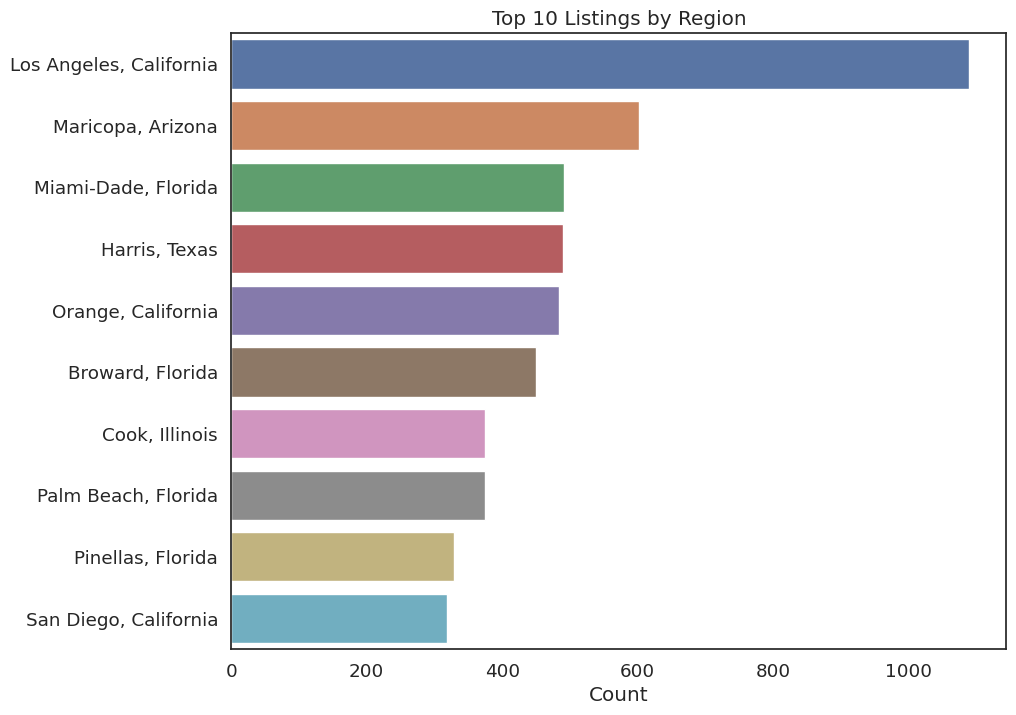

In [15]:
df=df_in
df['r']=df['COUNTY_NAME'] + ', ' + df['STATE_NAME']
region_vc=pd.DataFrame({'Count': df['r'].value_counts()})
sns.barplot(y=region_vc[0:10].index, x=region_vc[0:10]["Count"], orient='h')
plt.title("Top 10 Listings by Region")
plt.show()

### Categroy Info

In [16]:
df_in.iloc[0].categories

array(['Real Estate For Sale', 'New Jersey', 'Other', 'Mays Landing'],
      dtype=object)

In [17]:
df=df_in
df=df.explode('categories')

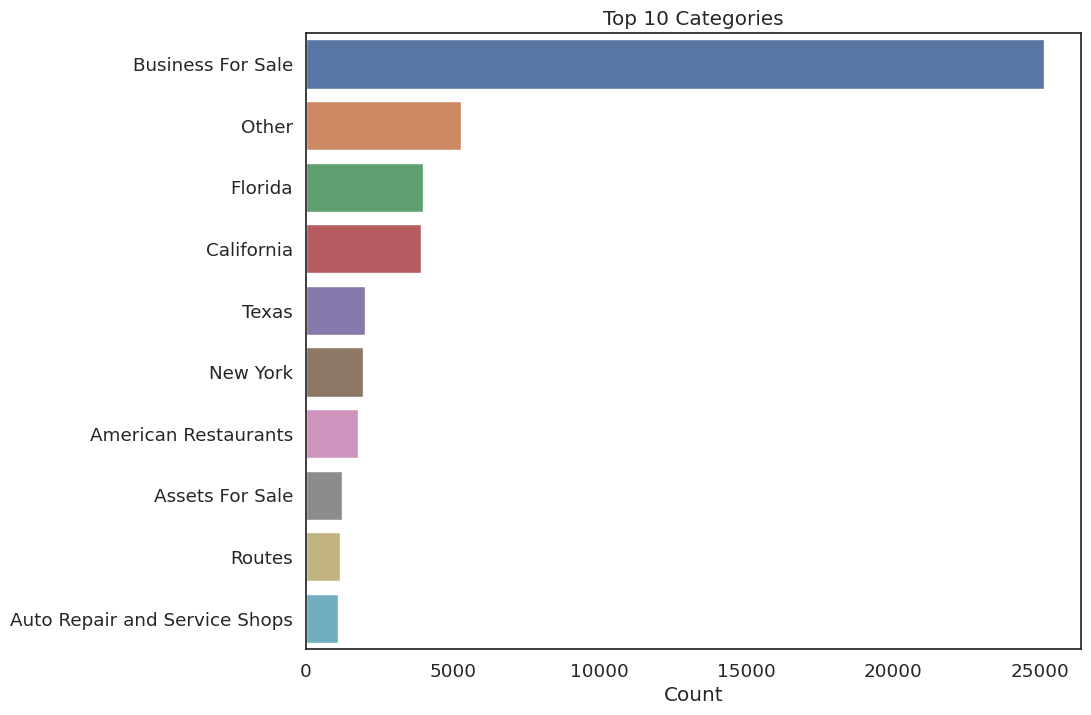

In [18]:
cat_vc=pd.DataFrame({'Count': df['categories'].value_counts()})
sns.barplot(y=cat_vc[0:10].index, x=cat_vc[0:10]["Count"], orient='h')
plt.title("Top 10 Categories")
plt.show()

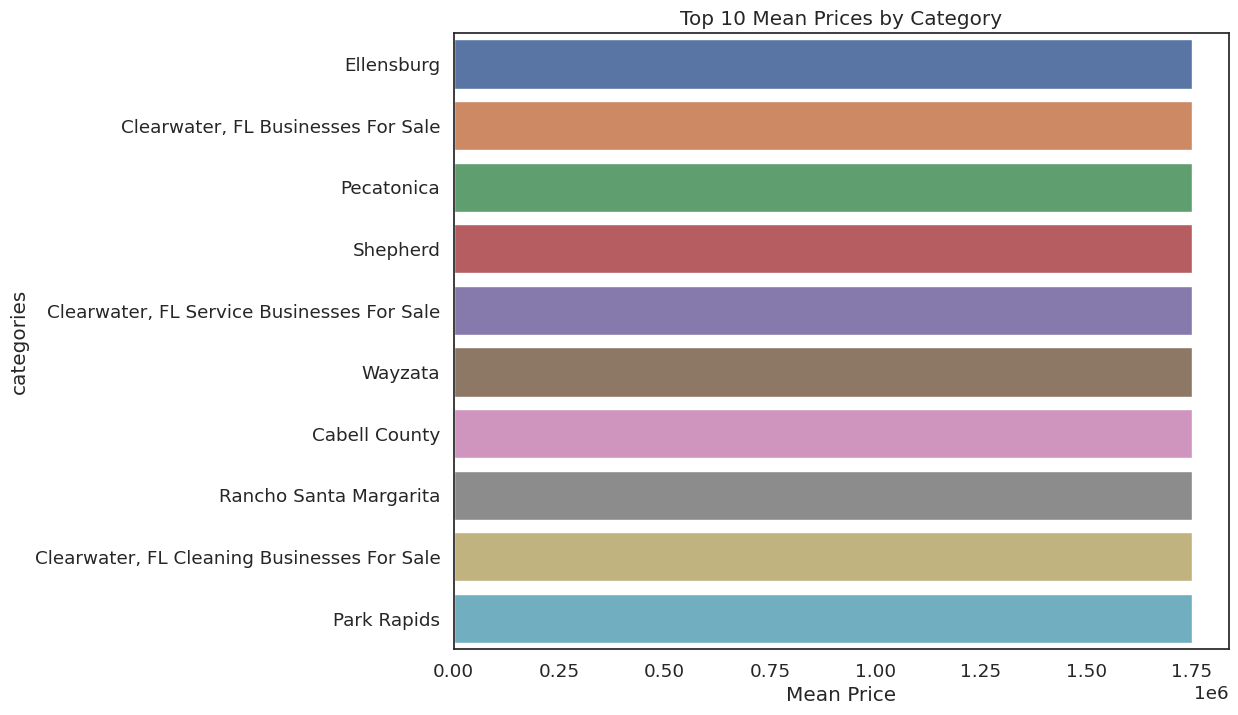

In [19]:
cat_price=pd.DataFrame({'Mean Price': df.groupby('categories')['price'].mean()})
cat_price.sort_values('Mean Price',ascending=False,inplace=True)
sns.barplot(y=cat_price[0:10].index, x=cat_price[0:10]['Mean Price'], orient='h')
plt.title("Top 10 Mean Prices by Category")
plt.show()

### Title stats

In [20]:
df_in.iloc[0].title

'High Exposure in Mays Landing, New Jersey - BizBuySell'

In [21]:
def count_words(x):
    return len(x.split())

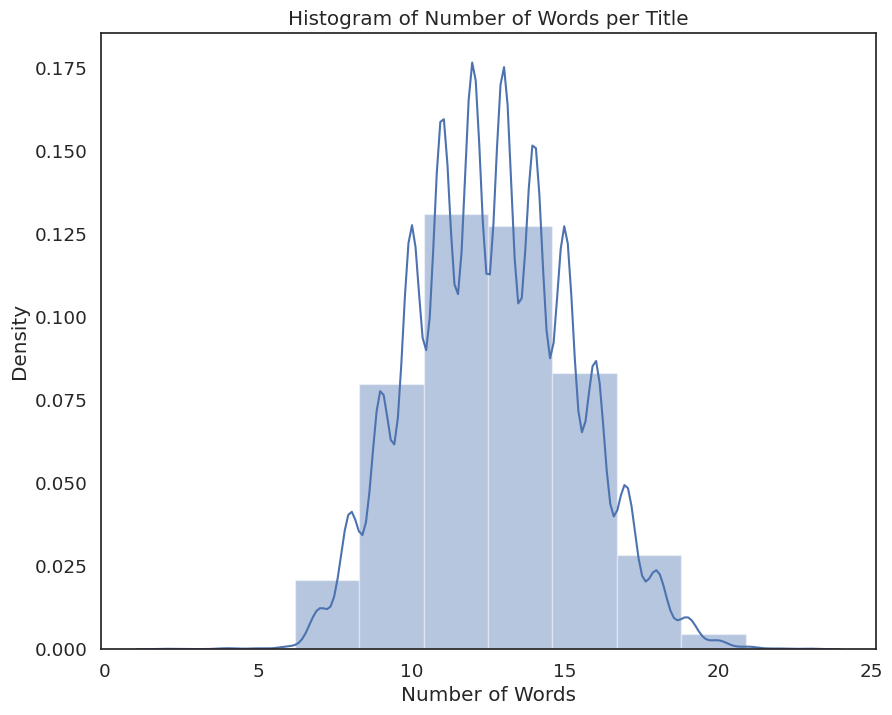

In [22]:
df=df_in
df["num_title_words"]=df["title"].apply(count_words)
sns.distplot(df["num_title_words"], bins=10)
plt.title("Histogram of Number of Words per Title")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.show()

In [23]:
df["num_title_words"].describe()

count    27338.000000
mean        12.662009
std          2.557936
min          2.000000
25%         11.000000
50%         13.000000
75%         14.000000
max         23.000000
Name: num_title_words, dtype: float64

In [24]:
def create_corpus(col):
    corpus = []
    for w in df[col].str.split():
        for i in w:
            if len(i)>1 and i.lower() not in ['bizbuysell']:
                corpus.append(i.lower())  
    return corpus

In [25]:
def create_corpus_sw_dict(col):
    corpus = create_corpus(col)       
    stop_dict = defaultdict(int)
    for word in corpus:
        if word in stopwords:
            stop_dict[word] += 1
    return sorted(stop_dict.items(), key=lambda x:x[1], reverse=True)

In [26]:
def create_corpus_dict(col):
    corpus = create_corpus(col)       
    word_dict = defaultdict(int)
    for word in corpus:
        if word not in stopwords:
            word_dict[word] += 1
    return sorted(word_dict.items(), key=lambda x:x[1], reverse=True)

In [27]:
corpus_title_sw_dict=create_corpus_sw_dict('title')
title_sw_x, title_sw_y = zip(*corpus_title_sw_dict)

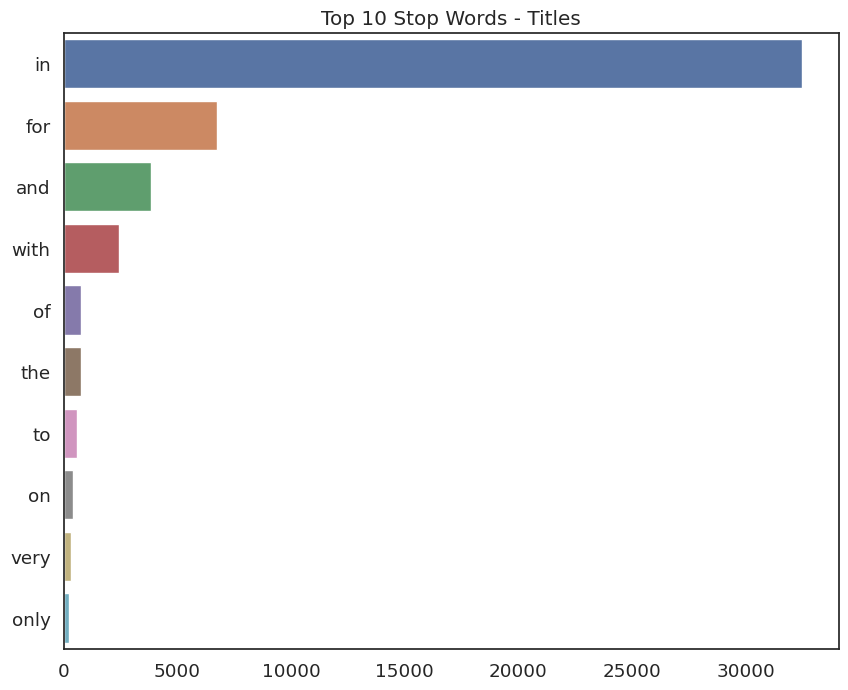

In [28]:
sns.barplot(y=list(title_sw_x)[0:10], x=list(title_sw_y)[0:10], orient='h')
plt.title("Top 10 Stop Words - Titles")
plt.show()

In [29]:
corpus_title_dict=create_corpus_dict('title')
title_x, title_y = zip(*corpus_title_dict)

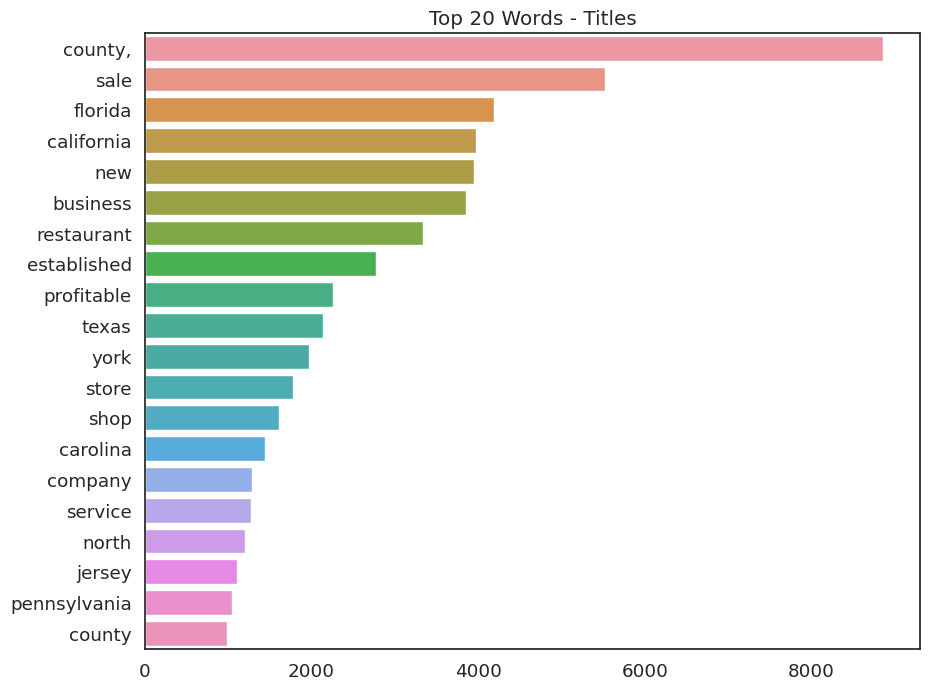

In [30]:
sns.barplot(y=list(title_x)[0:20], x=list(title_y)[0:20], orient='h')
plt.title("Top 20 Words - Titles")
plt.show()

### Description stats

In [31]:
df_in.iloc[0].desc

'AMAZING OPPORTUNITY! Priced to sell and ready for your business! Located in the Heart of Mays Landing across from a busy shopping center on a high traffic road. Zoned General commercial, recently renovated, public utilities. The possibilities are endless so call today!'

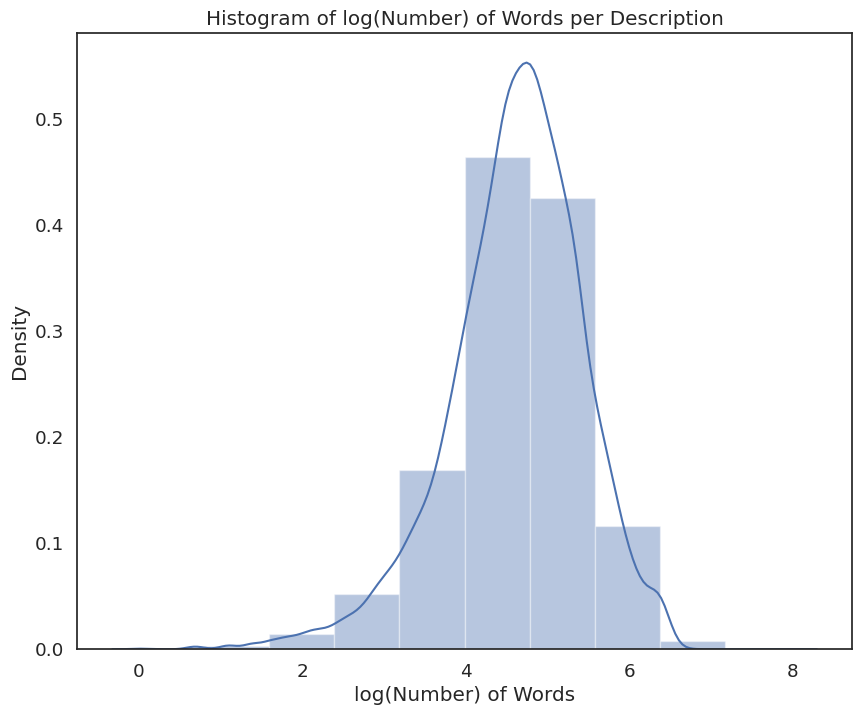

In [32]:
df=df_in
df["num_desc_words"]=df["desc"].apply(count_words)
sns.distplot(np.log(df["num_desc_words"]), bins=10)
plt.title("Histogram of log(Number) of Words per Description")
plt.xlabel("log(Number) of Words")
plt.ylabel("Density")
plt.show()

In [33]:
df["num_desc_words"].describe()

count    27338.000000
mean       134.459324
std        106.699785
min          1.000000
25%         64.000000
50%        107.000000
75%        173.000000
max       2900.000000
Name: num_desc_words, dtype: float64

In [34]:
corpus_desc_sw_dict=create_corpus_sw_dict('desc')
desc_sw_x, desc_sw_y = zip(*corpus_desc_sw_dict)

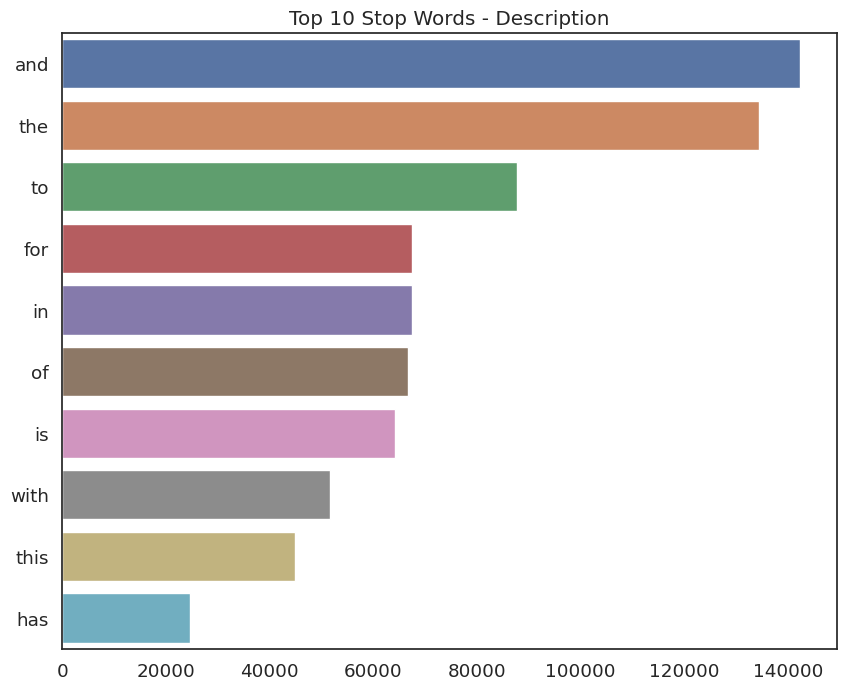

In [35]:
sns.barplot(y=list(desc_sw_x)[0:10], x=list(desc_sw_y)[0:10], orient='h')
plt.title("Top 10 Stop Words - Description")
plt.show()

In [36]:
corpus_desc_dict=create_corpus_dict('desc')
desc_x, desc_y = zip(*corpus_desc_dict)

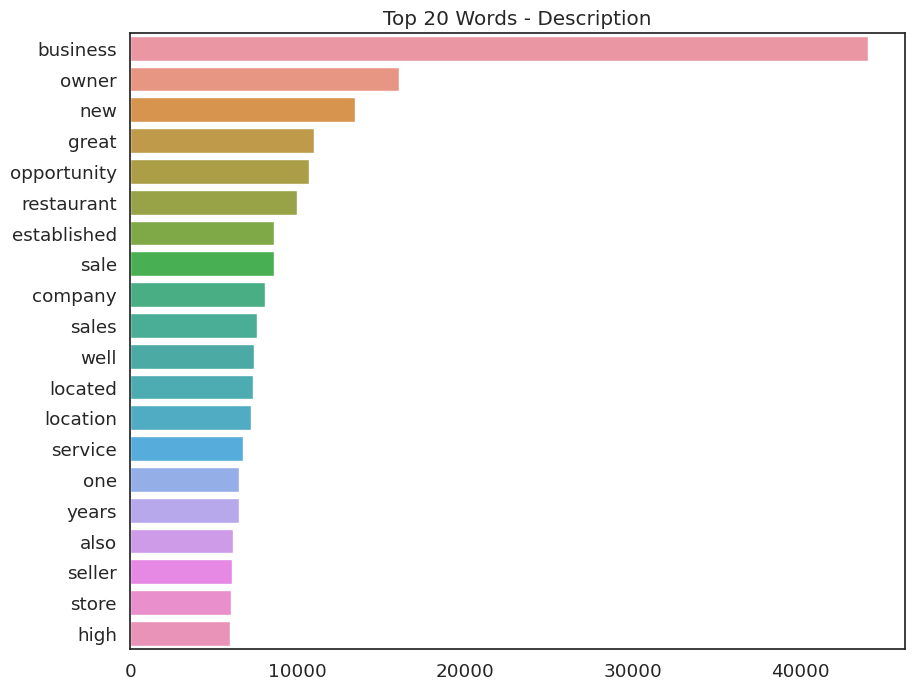

In [37]:
sns.barplot(y=list(desc_x)[0:20], x=list(desc_y)[0:20], orient='h')
plt.title("Top 20 Words - Description")
plt.show()

In [38]:
def bigrams():
    corpus = df["desc"]
    count_vec = CountVectorizer(ngram_range=(2, 2),stop_words=stopwords).fit(corpus)
    bag_of_words = count_vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [39]:
desc_bigrams=bigrams()[:20]
x_desc_bigrams, y_desc_bigrams = map(list, zip(*desc_bigrams))

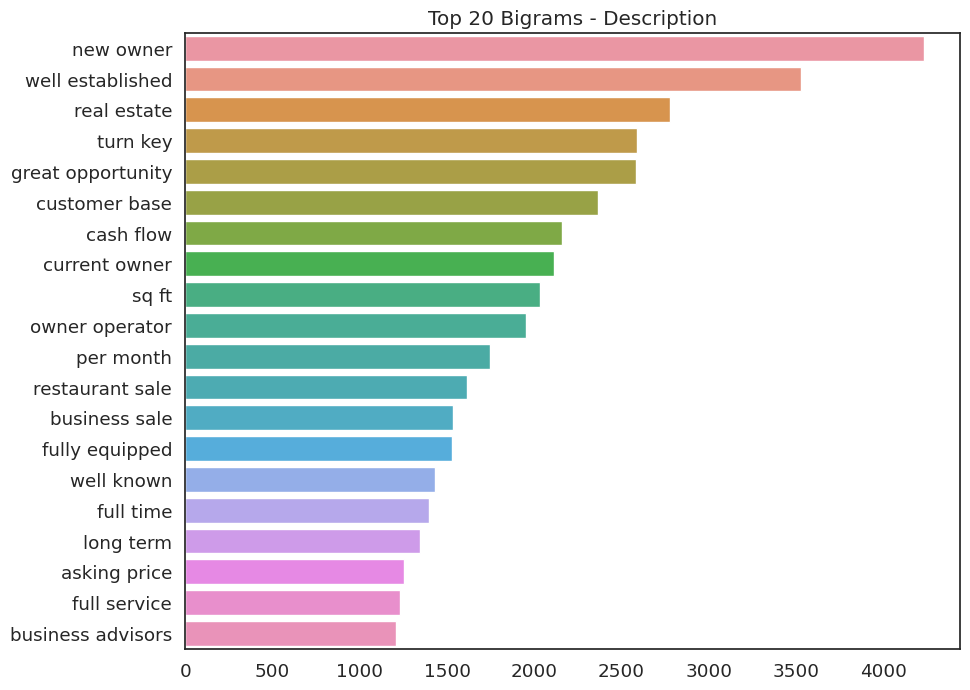

In [40]:
sns.barplot(x=y_desc_bigrams, y=x_desc_bigrams, orient='h')
plt.title("Top 20 Bigrams - Description")
plt.show()

In [41]:
def trigrams():
    corpus = df["desc"]
    count_vec = CountVectorizer(ngram_range=(3, 3),stop_words=stopwords).fit(corpus)
    bag_of_words = count_vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [42]:
desc_trigrams=trigrams()[:20]
x_desc_trigrams, y_desc_trigrams = map(list, zip(*desc_trigrams))

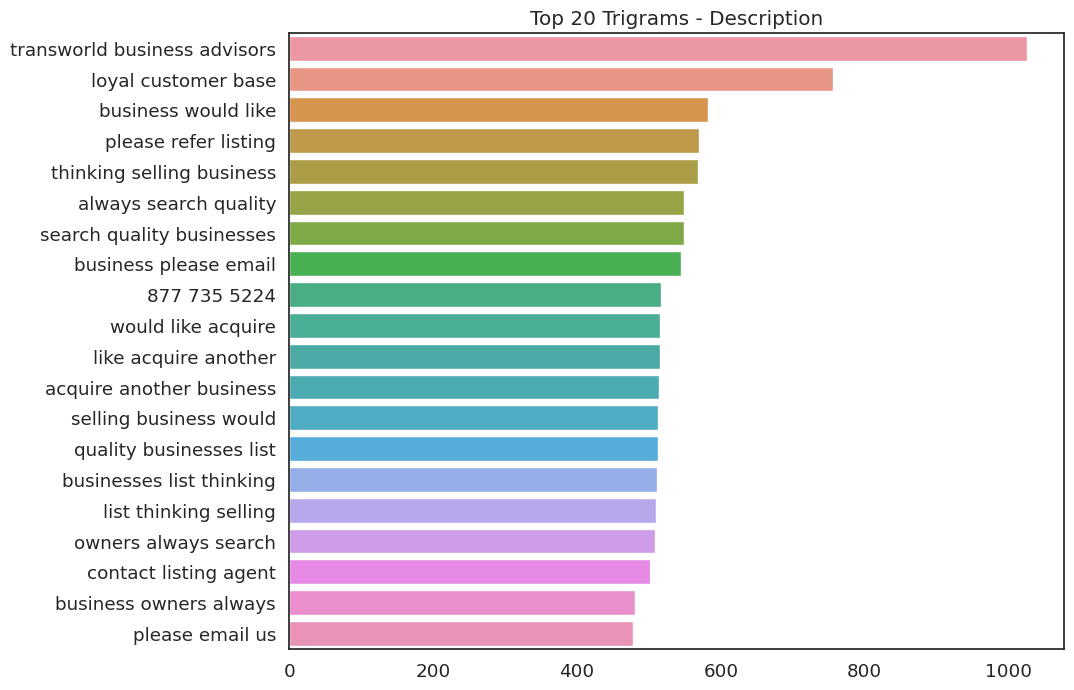

In [43]:
sns.barplot(x=y_desc_trigrams, y=x_desc_trigrams, orient='h')
plt.title("Top 20 Trigrams - Description")
plt.show()